        Date      Close
0 2010-06-29  23.889999
1 2010-06-30  23.830000
2 2010-07-01  21.959999
3 2010-07-02  19.200001
4 2010-07-06  16.110001
Training data shape: (1872, 60, 1) (1872,)
Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - loss: 0.0081 - val_loss: 5.8209e-04
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 6.2548e-04 - val_loss: 0.0014
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 6.0651e-04 - val_loss: 8.7102e-04
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 5.0287e-04 - val_loss: 7.5624e-04
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 4.3260e-04 - val_loss: 5.1822e-04
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 3.6456e-04 - val_loss: 4.5881e-04
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 3.6549e-04 - val_loss: 7.9058e-04
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 3.4968e-04 - val_loss: 8.8194e-04
Epoch 9/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 3.1612e-04 - val_

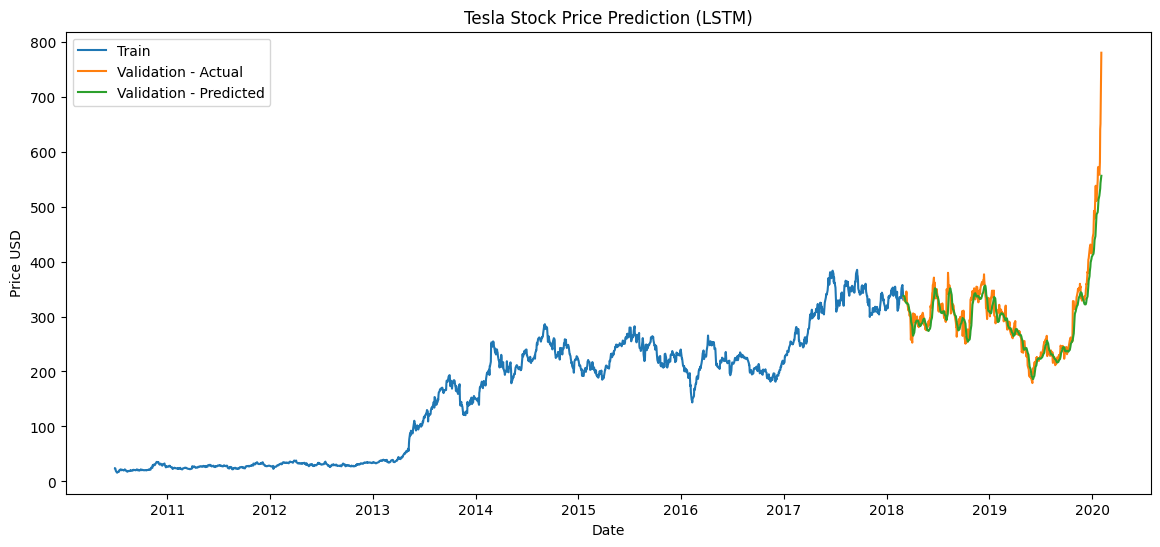

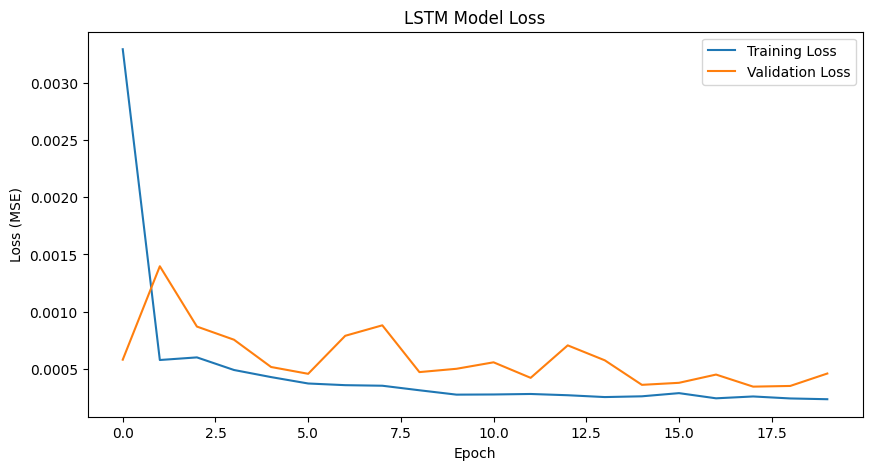

In [5]:
# Task 2 [ LTMS]
# Imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import math

# 1) Load dataset
# Kaggle dataset: Tesla stock 2010–2020
df = pd.read_csv("/kaggle/input/tesla-stock-data-from-2010-to-2020/TSLA.csv")

# Keep only Date and Close (for price prediction)
df['Date'] = pd.to_datetime(df['Date'])
df = df[['Date', 'Close']]
df = df.sort_values('Date')  # sort by date

print(df.head())

# 2) Preprocessing
# Convert to numpy array
data = df.filter(['Close']).values

# Scaling (LSTM needs scaled data)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

# Train/test split (80% train, 20% test)
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[:training_data_len]
test_data = scaled_data[training_data_len-60:]  # include last 60 days from training

# Create sequences
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_data, 60)
X_test, y_test = create_dataset(test_data, 60)

# Reshape for LSTM [samples, time_steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print("Training data shape:", X_train.shape, y_train.shape)

# 3) Build LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))  # prediction (next closing price)

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# 4) Train Model
history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_split=0.1)

# 5) Predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # reverse scaling

# Real prices
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))

# 6) Evaluations
rmse = math.sqrt(mean_squared_error(y_test_actual, predictions))
mae = mean_absolute_error(y_test_actual, predictions)

print("RMSE:", rmse)
print("MAE:", mae)

#  7) Plot Results 
train = df[:training_data_len]
valid = df[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(14,6))
plt.title('Tesla Stock Price Prediction (LSTM)')
plt.xlabel('Date')
plt.ylabel('Price USD')
plt.plot(train['Date'], train['Close'], label="Train")
plt.plot(valid['Date'], valid['Close'], label="Validation - Actual")
plt.plot(valid['Date'], valid['Predictions'], label="Validation - Predicted")
plt.legend()
plt.show()

# # 8) Plot Training & Validation Loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("LSTM Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()

